# What
Embed viewers and movies into a high dimensional space.

# Why 
Embeddings of movies and viewers can be used to make recommendations
in that viewers should like movies that are "close" to them in the 
  vector space.

Embeddings can even be used if there are no viewers.
For example, if we only have data on products, if the data is coview data
then we can use that to embed the products.
Then products close to each other should be reasonable substitutes.  

# Background

Here I use a move rating data set from Kaggle.
In this notebook I will derive embeddings for users and movies
and these will be the ingredients of a matrix factorization
of the full rating matrix.

We will train a simple Neural Net using Pytorch.

Evaluation is done using recommendations not seen in training, that is, 
we compare the actual recommendation to the model predicted one.

In [48]:
import os
import datetime
import pandas as pd
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### Use the GPU, i.e. cuda, if available

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

Device in use: cuda


In [50]:
## Read in the data and show shape and head

In [51]:
origdf = pd.read_csv("ratings.csv")
print(origdf.shape)
origdf.head(2)

(26024289, 4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [52]:
print(f"max userId {origdf.userId.max()} num users {origdf.userId.nunique()}")
print(f"max movieId {origdf.movieId.max()} num movies {origdf.movieId.nunique()}")

max userId 270896 num users 270896
max movieId 176275 num movies 45115


# Subsampling
The original dataset was too large for my Cuda memory
so I will subsample to a much saller set.

In [53]:
subsample = True
df = origdf.copy()
if subsample:
    max_user =  10000
    max_movie = 5000
    df = df.loc[df.movieId < max_movie]
    df = df.loc[df.userId < max_user]
    print(f"max userId {df.userId.max()} num users {df.userId.nunique()}")
    print(f"max movieId {df.movieId.max()} num movies {df.movieId.nunique()}")    
    print(df.shape)    

max userId 9999 num users 9930
max movieId 4999 num movies 4783
(676352, 4)


## Partition the dataset
Partition into train, val and test sets.
We can use val to tune the hyper parameters.

We could use the sklearn function but I find this just as easy
and I like keeping things as dataframes.

In [54]:
def partition(df, pct=0.1):
    size = int(np.floor(df.shape[0])*pct)
    idx = list(np.random.choice(df.index, size, replace=False))
    subset = df.filter(items=idx, axis=0)
    rest = df.drop(index = idx)
    return subset, rest

otherdf, traindf = partition(df, 0.3)
valdf, testdf = partition(otherdf, .5)
print(f"train {traindf.shape}  valid: {valdf.shape}, test: {testdf.shape}, ")
traindf.reset_index(inplace=True)
valdf.reset_index(inplace=True)
testdf.reset_index(inplace=True)

train (473447, 4)  valid: (101452, 4), test: (101453, 4), 


## the Model
The model is fairly simple: 2 embedding layers, 
    one each for users and movies.
    
At the end of "forward" we simply do the dot product of users and movie embeddings
which gives us the similarity or how much the model says a user likes a movie.
We can then compare to the actual ratings, get errors, et cetera.

In [55]:
class MF(nn.Module):
    def __init__(self, n_users, n_movies, emb_size=100):
        super(MF, self).__init__()
        self.n_users = n_users
        self.n_movies = n_movies
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.movie_emb = nn.Embedding(n_movies, emb_size)
        
        # initializing the matrices with a positive number 
        # supposed to help generally will yield better results
        self.user_emb.weight.data.uniform_(0, 0.5)
        self.movie_emb.weight.data.uniform_(0, 0.5)
    
    def forward(self, users, movies):
        m = self.movie_emb(movies)
        u = self.user_emb(users)
        return (u * m).sum(1)  # taking the dot product

## Dataset and dataloader
I want to use mini-batch training so we need a dataset
and a dataloader.

I adapted some code for converting a pandas dataframe into a dataloader

In [56]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        print(f" len {dataframe.shape[0]}")

    def __getitem__(self, index):
        userid = self.dataframe.userId[index]
        movieid = self.dataframe.movieId[index]
        rating = np.float32(self.dataframe.rating[index])
        return userid, movieid, rating

    def __len__(self):
        length = self.dataframe.shape[0]
        return length
                              
train_dataset = CustomDataset(dataframe=traindf)
train_dataloader = DataLoader(train_dataset, batch_size=64)

val_dataset = CustomDataset(dataframe=valdf)
val_dataloader = DataLoader(val_dataset, batch_size=64) 

test_dataset = CustomDataset(dataframe=testdf)
test_dataloader = DataLoader(test_dataset, batch_size=64) 


 len 473447
 len 101452
 len 101453


### Define the train loop

In [ ]:
def instantiate_model(n_users, n_movies, emb_size=64):
    n_users = df.userId.max()+1
    n_movies = df.movieId.max()+1
    model = MF(n_users=n_users, n_movies=n_movies, emb_size=emb_size)
    return model

loss_fn = F.mse_loss
    
# for now I am not experimenting with weight decay.  maybe later.
def train_model(model, epochs=2, lr=0.01, wd=0.0, use_cuda=False, print_freq=500):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    if use_cuda:
        if torch.cuda.is_available():
            model = model.to(device)
        else:
            print(f"cuda not available")

    start_dt = datetime.datetime.now()            
    #
    # train loop
    #
    model.train()
    train_rmse = []    
    val_rmse = []      
    for ei in range(epochs):
        epoch_mse = 0.0
        for tbi, data in enumerate(train_dataloader):
            users, movies, ratings = data
            if use_cuda:
                users = users.cuda()
                movies = movies.cuda()
                ratings = ratings.cuda()                   
            y_hat = model(users, movies)
            loss = loss_fn(y_hat, ratings)
            epoch_mse += loss.item() 
            optimizer.zero_grad()  # reset gradient
            loss.backward()
            optimizer.step() 
        mse = epoch_mse/len(train_dataloader)
        rmse = np.sqrt(mse)
        train_rmse.append(rmse)

    
        #    
        # eval loop
        #
        model.eval()        
        epoch_mse = 0.0        
        for tbi, data in enumerate(val_dataloader):
            users, movies, ratings = data
            if use_cuda:
                users = users.cuda()
                movies = movies.cuda()
                ratings = ratings.cuda()
            y_hat = model(users, movies)
            loss = loss_fn(y_hat, ratings)
            epoch_mse += loss.item()
        mse = epoch_mse/len(val_dataloader)
        rmse = np.sqrt(mse)
        val_rmse.append(rmse)
        
    print(f"\tdone {epochs} epochs,")
    
    
    df = pd.DataFrame()
    df["train"] = train_rmse
    df["val"] = val_rmse
    df["epoch"] = range(len(train_rmse))
    return df


### Try different hyperparameters
Loop over the train loop and try different embedding dimensions and learning rates.

In [58]:
n_users = df.userId.max()
n_movies = df.movieId.max()
dflist = []
models = {}
for epochs in [10]:
    for emb_size in [64, 128, 256]:
        print(f"emb size {emb_size}")
        for lr in [0.005, .0025, 0.001]:
            print(f"  learning rate{lr}")            
            model = instantiate_model(n_users=n_users, n_movies=n_movies, emb_size=emb_size)
            tdf = train_model(model=model, epochs=epochs, lr=lr, wd=0.0, use_cuda=True, print_freq=5000)
            tdf["emb_size"] = emb_size
            tdf["lr"] = lr
            dflist.append(tdf)
            models[emb_size] = model
resdf = pd.concat(dflist)

emb size 64
  learning rate0.005
	done 10 epochs,
  learning rate0.0025
	done 10 epochs,
  learning rate0.001
	done 10 epochs,
emb size 128
  learning rate0.005
	done 10 epochs,
  learning rate0.0025
	done 10 epochs,
  learning rate0.001
	done 10 epochs,
emb size 256
  learning rate0.005
	done 10 epochs,
  learning rate0.0025
	done 10 epochs,
  learning rate0.001
	done 10 epochs,


## Plot the errors
I'll use Plotnine, an implmentantion of ggplot, to plot the errors for each learning rate and embedding size  
for both train and validation sets.

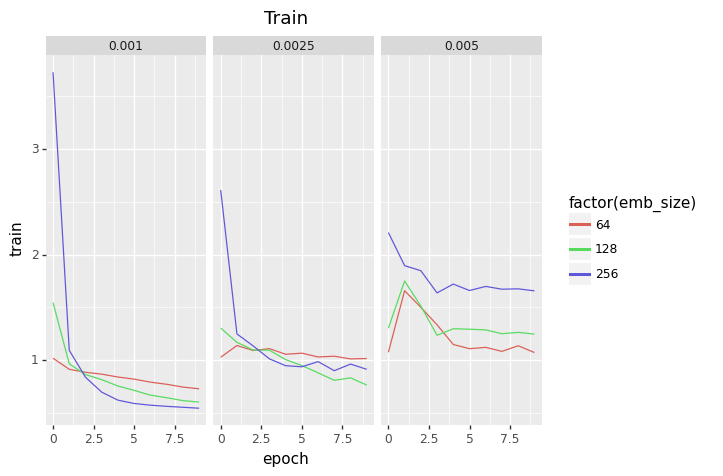

<ggplot: (8781101443069)>

In [59]:
import plotnine
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line, labels

(ggplot(resdf, aes('epoch', 'train',  color='factor(emb_size)'))
 + geom_line()
 + labels.ggtitle("Train")
 + facet_wrap('~lr'))

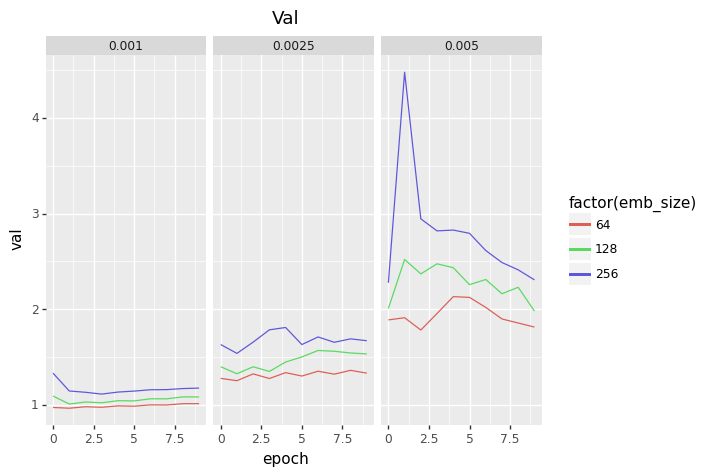

<ggplot: (8781101457243)>

In [60]:
(ggplot(resdf, aes('epoch', 'val',  color='factor(emb_size)'))
 + geom_line() 
 + labels.ggtitle("Val")
 + facet_wrap('~lr'))

# Summary of training
* the smallest learning rate seemed to perform best
* the larger embedding sizes probably overfit given the larger learning rates

Although they all seemed fine for the smallest learning rate
         for the validation set.

So to go forward I would use
* learning rate = 0.001
* embedding size = 64 or 128


In [61]:
loss_fn = F.mse_loss
def run_test(use_cuda, emb_size):
    model = instantiate_model(n_users=n_users, n_movies=n_movies, emb_size=emb_size)
    if use_cuda:
        if torch.cuda.is_available():
            model = model.to(device)
        else:
            print(f"cuda not available")    
    model.eval()        
    epoch_mse = 0.0        
    for tbi, data in enumerate(test_dataloader):
        users, movies, ratings = data
        if use_cuda:
            users = users.cuda()
            movies = movies.cuda()
            ratings = ratings.cuda()
        y_hat = model(users, movies)
        loss = loss_fn(y_hat, ratings)
        epoch_mse += loss.item()
    mse = epoch_mse/len(test_dataloader)
    rmse = np.sqrt(mse)
    return (rmse)
emb_size = 64
test_err = run_test(use_cuda=True, emb_size=emb_size)
print(f"test err {np.round(test_err, 2)} for emb_size {emb_size}")

test err 1.23 for emb_size 64


### Error comments
So an error of 1.2 is slightly higher than the val error 
and definitely higher than the train error, both of which are 
to be expected.

But we fixed the model parameters before running the test, 
so no going back now.

Anyway, the range for the recommendations is 0.5 to 5.0, so being off by 1.25 seems pretty good.

Note that this is loosly based on some code from   
https://betterprogramming.pub/building-a-recommendation-engine-with-pytorch-d64be4856fe7